In [1]:
import numpy as np
import time
from numba import cuda

threadsperblock = 128

In [2]:
def vec_sum_cpu(vec_size):
    vec = np.random.rand(vec_size).astype(np.float64)
    res = np.sum(vec)
    start_time = time.time()
    summ = 0
    for i in range(vec_size):
        summ += vec[i]

    end_time = time.time()
    return abs(summ - res) < 0.00001, end_time - start_time

In [3]:
vector_sizes = [1000 + i * 9990 for i in range(100)]

solutions_c = []

for vector_size in vector_sizes:
    sum_t = 0
    for i in range(12):
        flag, t = vec_sum_cpu(vector_size)
        if not flag:
            print("Алгоритм сработал не верно.")
        sum_t += t
    solutions_c.append(sum_t / 12)

# Сохранение списка в текстовый файл
with open('my_list.txt', 'w') as file:
    for item in solutions_c:
        file.write(f'{item}\n')  # Записываем каждый элемент на новой строке

In [7]:
@cuda.jit
def vec_sum_gpu(vec, part):
    # Выделяем shared memory для частичных сумм внутри каждого блока
    shared = cuda.shared.array(threadsperblock, dtype=np.float64)

    thread_id = cuda.threadIdx.x
    idx = cuda.grid(1)

    # Каждый поток загружает свой элемент в shared memory, если он в пределах вектора
    if idx < vec.size:
        shared[thread_id] = vec[idx]
    else:
        shared[thread_id] = 0.0

    cuda.syncthreads()

    # Редукция в shared memory
    i = cuda.blockDim.x // 2
    while i > 0:
        if thread_id < i:
            shared[thread_id] += shared[thread_id + i]
        cuda.syncthreads()
        i //= 2

    # Результат редукции записываем в массив частичных сумм
    if thread_id == 0:
        part[cuda.blockIdx.x] = shared[0]

In [8]:
def sum_gpu(vec_size):
    vec = np.random.rand(vec_size).astype(np.float64)
    res = np.sum(vec)

    start_time = time.time()
    dvec = cuda.to_device(vec)

    blocks_per_grid = (vec.size + threadsperblock - 1) // threadsperblock
    dparts = cuda.device_array((blocks_per_grid,), dtype=np.float64)

    threads_per_block = 128
    vec_sum_gpu[blocks_per_grid, threads_per_block](dvec, dparts)

    # Копируем частичные суммы обратно на CPU и суммируем их
    dparts = dparts.copy_to_host()
    summ = np.sum(dparts)

    end_time = time.time()
    return abs(summ - res) < 0.0001, end_time - start_time

In [9]:
import matplotlib.pyplot as plt

vector_sizes = [1000 + i * 9990 for i in range(100)]

solutions_g = []

for vector_size in vector_sizes:
    flag = True
    sum_t = 0
    for i in range(12):
        flag, t = sum_gpu(vector_size)
        if not flag:
            print("Алгоритм сработал не верно.")
        sum_t += t
    solutions_g.append(t / 12)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 86 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [10]:
# Сохранение списка в текстовый файл
with open('my_list1.txt', 'w') as file:
    for item in solutions_g:
        file.write(f'{item}\n')  # Записываем каждый элемент на новой строке
len(solutions_g)

100

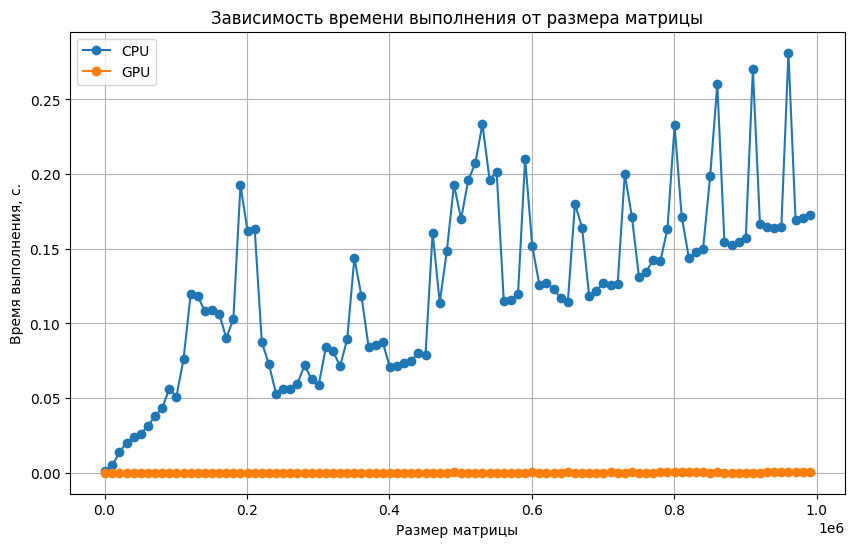

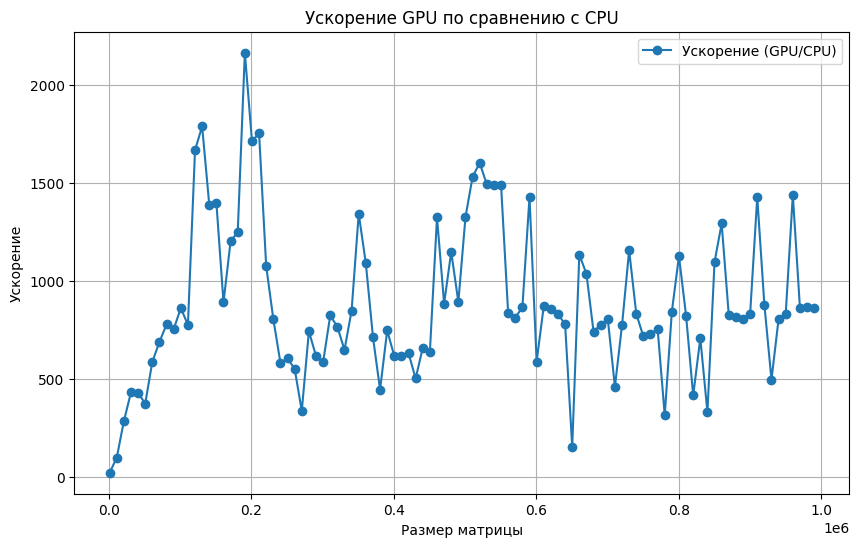

In [11]:
solutions_c = [float(item) for item in open('my_list.txt')]

plt.figure(figsize=(10, 6))
plt.plot(vector_sizes, solutions_c, label="CPU", marker='o')
plt.plot(vector_sizes, solutions_g, label="GPU", marker='o')
plt.title("Зависимость времени выполнения от размера матрицы")
plt.xlabel("Размер матрицы")
plt.ylabel("Время выполнения, c.")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(vector_sizes, [i / j for i, j in zip(solutions_c, solutions_g)], label="Ускорение (GPU/CPU)", marker='o')
plt.title("Ускорение GPU по сравнению с CPU")
plt.xlabel("Размер матрицы")
plt.ylabel("Ускорение")
plt.legend()
plt.grid(True)
plt.show()
